In [0]:
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


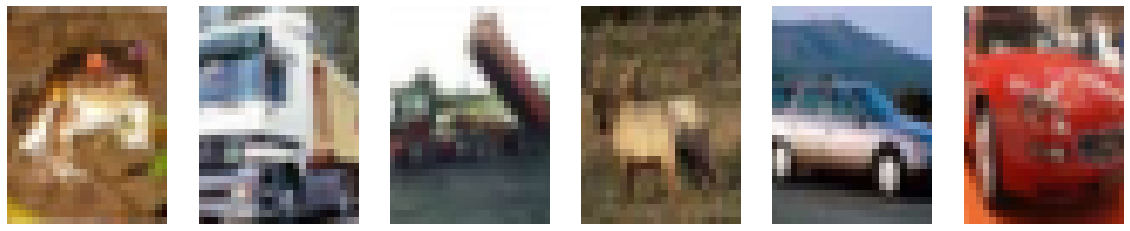

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


#check for some images
fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=6, sharey=True, sharex=False)

for i in range(6):
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  im = axes[i].imshow(X_train[i])

In [0]:
class DCGAN:
  def __init__(self, x_train, gen_dims=100):
        """
            Initializes the Deep Convolutional Gan
            
            Ags:
                x_train (np.array): the set we want to sample generated images from
                gen_dims (int): dimension of the noise for the generated images
        """
        
        self.training_set = x_train
        self.samples = []  # empty array to hold the samples
        self.losses = []  # empty array to hold the losses
        self.gen_dims = gen_dims
        self.weights = []
        
      
  def __generator(self, input_layer, kernel_size=5, reuse=False, lrelu_slope=0.2,
             kernel_initializer=tf.contrib.layers.xavier_initializer(), training=True):
    
    w_init = kernel_initializer
    with tf.variable_scope('generator', reuse=reuse):
      
    
      #Noise to volume
      input_dense = tf.layers.dense(inputs=input_layer, units=2*2*256)
      input_volume = tf.reshape(tensor=input_dense, shape=(-1,2,2,256))
      h1 = tf.layers.batch_normalization(inputs=input_volume, training=training)
      h1 = tf.maximum(h1*lrelu_slope,h1)
      # 2x2x256
    
      #upsample
      h2 = tf.layers.conv2d_transpose(filters=128, strides=2, kernel_size = kernel_size,
                                     padding='same', inputs=h1, activation=None,
                                     kernel_initializer=w_init)
      h2 = tf.layers.batch_normalization(inputs=h2, training=training)
      h2 = tf.maximum(h2*lrelu_slope,h2)
      # 4x4x128
      
      #upsample
      h3 = tf.layers.conv2d_transpose(filters=64, strides=2, kernel_size = kernel_size,
                                     padding='same', inputs=h2, activation=None,
                                     kernel_initializer=w_init)
      h3 = tf.layers.batch_normalization(inputs=h3, training=training)
      h3 = tf.maximum(h3*lrelu_slope,h3)
      # 8x8x64
    
      #upsample
      h4 = tf.layers.conv2d_transpose(filters=32, strides=2, kernel_size = kernel_size,
                                     padding='same', inputs=h3, activation=None,
                                     kernel_initializer=w_init)
      h4 = tf.layers.batch_normalization(inputs=h4, training=training)
      h4 = tf.maximum(h4*lrelu_slope,h4)
      # 16x16x32
    
      #upsample
      h5 = tf.layers.conv2d_transpose(filters=3, strides=2, kernel_size = kernel_size,
                                     padding='same', inputs=h4, activation=None,
                                     kernel_initializer=w_init)
      # 32x32x3
    
      #output
      out = tf.tanh(x=h5)
    
      return out
    
  def __discriminator(self, input_layer, reuse=False, lrelu_slope=0.2,
             kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_size=5):
    
    w_init=kernel_initializer
  
    with tf.variable_scope('discriminator', reuse=reuse):
          
      #conv - 32x32x3 -> 16x16x64
      h1 = tf.layers.conv2d(inputs=input_layer, filters=32, strides=2,
                           kernel_size=kernel_size, padding='same',
                           kernel_initializer=w_init)
      h1 = tf.maximum(h1*lrelu_slope, h1)
    
      #16x16x64 -> 8x8x128
      h2 = tf.layers.conv2d(inputs=h1, filters=64, strides=2,
                           kernel_size=kernel_size, padding='same',
                           kernel_initializer=w_init)
      h2 = tf.layers.batch_normalization(inputs=h2, training=True)
      h2 = tf.maximum(h2*lrelu_slope, h2)
    
      # 8x8x128 -> 4x4x256
      h3 = tf.layers.conv2d(inputs=h2, filters=128, strides=2,
                           kernel_size=kernel_size, padding='same',
                           kernel_initializer=w_init)
      h3 = tf.layers.batch_normalization(inputs=h3, training=True)
      h3 = tf.maximum(h3*lrelu_slope, h3)
    
      # 4x4x256 -> 2x2x512
      h4 = tf.layers.conv2d(inputs=h3, filters=256, strides=2,
                           kernel_size=kernel_size, padding='same',
                           kernel_initializer=w_init)
      h4 = tf.layers.batch_normalization(inputs=h4, training=True)
      h4 = tf.maximum(h4*lrelu_slope, h4)
    
      flatten = tf.reshape(tensor=h4, shape=(-1, 2*2*256))
     
      h5 = tf.layers.dense(inputs=flatten, units=1, activation=None,
                          kernel_initializer=w_init)
    
      out = tf.sigmoid(x=h5)
    
      return out
  
  def __inputs(self):
          
    # define the input placeholders
    gen_input = tf.placeholder(shape=(None, self.gen_dims), dtype=tf.float32)
    real_input = tf.placeholder(shape=(None, 32, 32, 3), dtype=tf.float32)
        
    return gen_input, real_input 
  
  def lossesAndOptimizers(self, lr=0.0005, beta1=0.5, beta2=0.999):
 
    tf.reset_default_graph()

    # define the input placeholders
    gen_input, real_input = self.__inputs()

    # build the generator
    gen_images = self.__generator(input_layer=gen_input, 
                                  kernel_size=5, 
                                  reuse=False, 
                                  lrelu_slope=0.2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  training=True)

    # build the discriminator for the real images
    disc_output_real_image, disc_logits_real_image = self.__discriminator(input_layer=real_input, 
                                                                          reuse=False, 
                                                                          lrelu_slope=0.2,
                                                                          kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                                                          kernel_size=5)

    # build the discriminator for fake images
    # reuse the variables that we have from the real images
    disc_output_gen_image, disc_logits_gen_image = self.__discriminator(input_layer=gen_images, 
                                                                        reuse=True, 
                                                                        lrelu_slope=0.2, 
                                                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                                                        kernel_size=5)

    # - - - LOSSES - - -
    # generator loss
    gen_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_gen_image, multi_class_labels=tf.ones_like(disc_logits_gen_image)))

    # discriminator loss
    disc_loss_real_images = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_real_image, multi_class_labels=tf.ones_like(disc_logits_real_image)))
    disc_loss_gen_images = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_gen_image, multi_class_labels=tf.zeros_like(disc_logits_gen_image)))
    disc_loss = disc_loss_real_images + disc_loss_gen_images

    # get the variables for the generator and discriminator
    generator_variables = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    discriminator_variables = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

    # setup the optimizers
    # comtrol for the global sample mean and variance
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        generator_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(gen_loss, var_list=generator_variables)
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(disc_loss, var_list=discriminator_variables)

    return discriminator_optimizer, generator_optimizer, disc_loss, gen_loss, gen_input, real_input
  
    
  def train(self, batch_size=128, epochs=100):
    d_opt, g_opt, d_loss, g_loss, gen_input, real_input = self.lossesAndOptimizers()
    with tf.Session() as sess:

      # initialize the variables
      sess.run(tf.global_variables_initializer())

      # train the network
      for epoch in tqdm(range(epochs)):

        for step, batch in enumerate(self.__next_batch(self.training_set, batch_size)):
          
          noise = np.random.uniform(low=-1, high=1, size=(batch_size, self.gen_dims))

          # feed the noise through the generator
          _ = sess.run(g_opt, feed_dict={gen_input: noise, real_input: batch})

          # feed the channel and the noise to the discriminator
          _ = sess.run(d_opt, feed_dict={gen_input: noise, real_input: batch})

          # get the generator and discriminator losses
          gen_loss, disc_loss = sess.run([g_loss, d_loss], feed_dict={gen_input: noise, real_input: batch})

          # append all the losses on every iteration
          self.losses.append((gen_loss, disc_loss))

          # every second epoch
          if epoch % 2 == 0:
            
            # sample more noise
            sample_noise = np.random.uniform(low=-1, high=1, size=(72, self.gen_dims))

            # generate images
            gen_samples = sess.run(self.__generator(gen_input, reuse=True, training=False), feed_dict={gen_input: sample_noise})

            # append the images to the samples
            self.samples.append(gen_samples)

            # view samples from the last epoch
            _ = self.view_samples(-1, self.samples, 6, 12, figsize=(10,5))
            plt.show()
            
  def __next_batch(self, data, batch_size=128):
 
    # get the number of partitions
    number_of_partitions = data.shape[0]//batch_size

    # shuffle the examples
    np.random.shuffle(self.training_set)

    # partition the examples
    for batch in np.array_split(self.training_set[:number_of_partitions*batch_size], number_of_partitions):
      yield batch * 2 - 1  # scale to -1 to 1
            
  def view_samples(self, epoch, samples, nrows, ncols, figsize=(5, 5)):
        
    # ge the figure and the axes
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)

    # draw the samples
    for ax, img in zip(axes.flatten(), samples[epoch]):
      ax.axis('off')
      img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
      ax.set_adjustable('box-forced')
      im = ax.imshow(img, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes    
  
   
  

In [0]:
gan = DCGAN(X_train)

In [0]:
gan.train(batch_size=128, epochs=20)